<a href="https://colab.research.google.com/github/youssef-snoussi/Deep-Learning-Pro/blob/master/Brain_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
## Downloading the data from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yulolollo","key":"e95f961c5bb8087116aa61cf1126ad7e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 703M/714M [00:05<00:00, 87.9MB/s]
100% 714M/714M [00:05<00:00, 133MB/s] 


In [3]:
!unzip -q "/content/lgg-mri-segmentation.zip"

In [4]:
import pandas as pd

path = '/content/kaggle_3m/'
data = pd.read_csv(path + f"/data.csv")
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


## Getting images paths

In [5]:
import glob
import os

data_map = []
for dir in glob.glob(path+'*'):
    try:
        dir_name = dir.split('/')[-1]
        for file in os.listdir(dir):
            image_path = dir + '/' + file
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
1,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
2,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
3,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
4,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...


In [7]:
len(df['path'][1])

69

In [8]:
import random

df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 74
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : x[:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_13.tif 
Path to the Mask: /content/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_13_mask.tif


## Final Dataset
Here we prepare a dataframe with images and their correspnding masks and their paths with an additional colmn indicating if it's infected or not 

In [9]:
import numpy as np
import cv2

# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
1,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
2,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
3,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
4,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
...,...,...,...,...
3924,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


# Data visualisation

In [10]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Text(0.5, 1.0, 'Tumor Location')

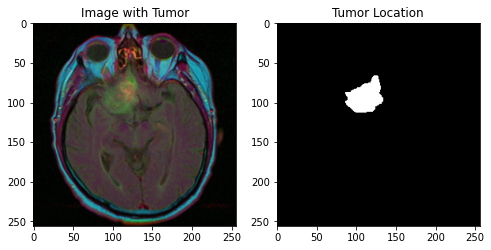

In [11]:
import matplotlib.pyplot as plt

for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.image_path[i]))
plt.title('Image with Tumor')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.mask_path[i]))
plt.title('Tumor Location')

# Spliting the Data into Train Test and Validation sets

In [12]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [14]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Pretrained models Benchmark 

In [15]:
from keras.applications.vgg16 import preprocess_input, VGG16
# load model without output layer
model = VGG16(input_shape = [256, 256, 3], weights = "imagenet", include_top=False)

model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [16]:
from keras.layers import Dense, Flatten

x = Flatten()(model.output)
pre = Dense(2, activation = "sigmoid")(x)

In [17]:
from keras.models import Model
model_vgg16 = Model(inputs = model.input, outputs = pre)

In [18]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
model_vgg16.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])
history_vgg16 = model_vgg16.fit_generator(train_generator, validation_data=valid_generator, epochs = 15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
188/188 [==============================] - 25s 91ms/step - loss: 0.5349 - accuracy: 0.7590 - val_loss: 0.3471 - val_accuracy: 0.8228
Epoch 2/15
188/188 [==============================] - 15s 82ms/step - loss: 0.2805 - accuracy: 0.8708 - val_loss: 0.4017 - val_accuracy: 0.7928
Epoch 3/15
188/188 [==============================] - 16s 83ms/step - loss: 0.2289 - accuracy: 0.9051 - val_loss: 0.3216 - val_accuracy: 0.8438
Epoch 4/15
188/188 [==============================] - 16s 84ms/step - loss: 0.2074 - accuracy: 0.9117 - val_loss: 0.2459 - val_accuracy: 0.9039
Epoch 5/15
188/188 [==============================] - 16s 85ms/step - loss: 0.1448 - accuracy: 0.9522 - val_loss: 0.2766 - val_accuracy: 0.8829
Epoch 6/15
188/188 [==============================] - 16s 87ms/step - loss: 0.1297 - accuracy: 0.9583 - val_loss: 0.2394 - val_accuracy: 0.8919
Epoch 7/15
188/188 [==============================] - 17s 89ms/step - loss: 0.1164 - accuracy: 0.9619 - val_loss: 0.2495 - val_accuracy:

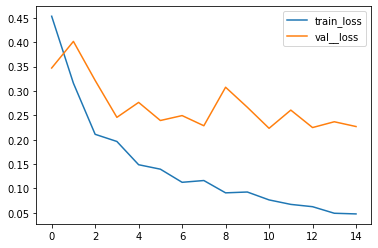

In [24]:
plt.plot(rhistory_vgg16.history["loss"], label = "train_loss")
plt.plot(rhistory_vgg16.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

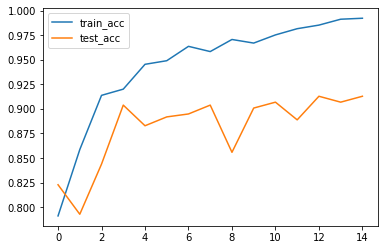

In [25]:
plt.plot(rhistory_vgg16.history["accuracy"], label = "train_acc")
plt.plot(rhistory_vgg16.history["val_accuracy"], label = "test_acc")
plt.legend()
plt.show()

In [26]:
from tensorflow import keras
# Fine tning 
# Unfreeze the base model
model_vgg16.trainable = True

model_vgg16.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Train end-to-end. Be careful to stop before you overfit!
result_model = model_vgg16.fit(train_generator, validation_data=valid_generator, epochs = 7)

Epoch 1/7
188/188 [==============================] - 55s 285ms/step - loss: 0.0896 - accuracy: 0.9630 - val_loss: 0.1991 - val_accuracy: 0.9339
Epoch 2/7
188/188 [==============================] - 52s 275ms/step - loss: 0.0381 - accuracy: 0.9895 - val_loss: 0.2128 - val_accuracy: 0.9309
Epoch 3/7
188/188 [==============================] - 52s 277ms/step - loss: 0.0426 - accuracy: 0.9849 - val_loss: 0.2773 - val_accuracy: 0.9339
Epoch 4/7
188/188 [==============================] - 52s 276ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 0.2763 - val_accuracy: 0.9069
Epoch 5/7
188/188 [==============================] - 52s 276ms/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 0.1994 - val_accuracy: 0.9309
Epoch 6/7
188/188 [==============================] - 52s 277ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1992 - val_accuracy: 0.9279
Epoch 7/7
188/188 [==============================] - 52s 277ms/step - loss: 9.4347e-04 - accuracy: 1.0000 - val_loss: 0.2172 - val_accur

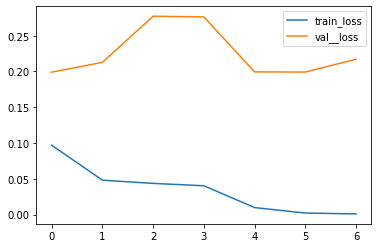

In [27]:
plt.plot(result_model.history["loss"], label = "train_loss")
plt.plot(result_model.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

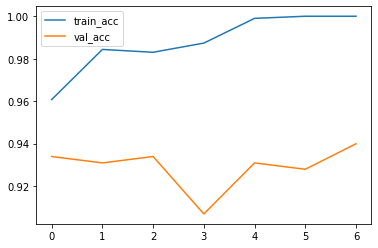

In [28]:
plt.plot(result_model.history["accuracy"], label = "train_acc")
plt.plot(result_model.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [40]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(input_shape = [256, 256, 3], weights = "imagenet", include_top=False)

model.trainable = False

In [41]:
x = Flatten()(model.output)
pre = Dense(2, activation = "sigmoid")(x)

In [42]:
model_Inceptionv3 = Model(inputs = model.input, outputs = pre)

In [43]:
model_Inceptionv3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [44]:
model_Inceptionv3.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [45]:
result_model = model_Inceptionv3.fit_generator(train_generator, validation_data=valid_generator, epochs = 15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
188/188 [==============================] - 17s 70ms/step - loss: 1.9115 - accuracy: 0.7509 - val_loss: 0.6150 - val_accuracy: 0.8348
Epoch 2/15
188/188 [==============================] - 11s 60ms/step - loss: 0.3406 - accuracy: 0.9181 - val_loss: 0.8663 - val_accuracy: 0.8228
Epoch 3/15
188/188 [==============================] - 11s 61ms/step - loss: 0.1638 - accuracy: 0.9563 - val_loss: 1.5223 - val_accuracy: 0.7628
Epoch 4/15
188/188 [==============================] - 11s 61ms/step - loss: 0.3118 - accuracy: 0.9338 - val_loss: 0.6725 - val_accuracy: 0.8769
Epoch 5/15
188/188 [==============================] - 11s 60ms/step - loss: 0.1551 - accuracy: 0.9732 - val_loss: 0.5943 - val_accuracy: 0.8949
Epoch 6/15
188/188 [==============================] - 11s 59ms/step - loss: 0.0501 - accuracy: 0.9920 - val_loss: 0.9499 - val_accuracy: 0.8589
Epoch 7/15
188/188 [==============================] - 11s 59ms/step - loss: 0.0602 - accuracy: 0.9953 - val_loss: 1.1406 - val_accuracy:

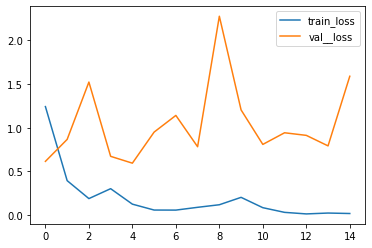

In [46]:
plt.plot(result_model.history["loss"], label = "train_loss")
plt.plot(result_model.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

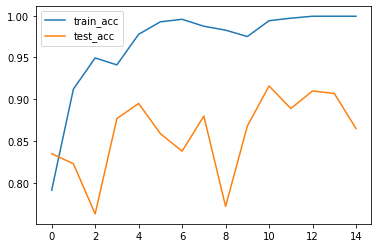

In [47]:
plt.plot(result_model.history["accuracy"], label = "train_acc")
plt.plot(result_model.history["val_accuracy"], label = "test_acc")
plt.legend()
plt.show()

In [48]:
# Unfreeze the base model
model.trainable = True

model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Train end-to-end. Be careful to stop before you overfit!
result_model = model_vgg6.fit(train_generator, validation_data=valid_generator, epochs = 7)

Epoch 1/7


InvalidArgumentError: ignored